In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# CV的迁移学习
**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

使用迁移学习训练卷积神经网络进行图像分类。 [cs231n notes](https://cs231n.github.io/transfer-learning/)_

Quoting these notes,

   实际上，很少有人从头开始训练整个卷积网络（使用随机初始化），因为拥有足够大的数据集相对较为罕见。相反，通常会在一个非常大的数据集上（例如ImageNet，其中包含120万张图像，分为1000个类别）上预训练卷积网络，然后将该卷积网络用作感兴趣任务的初始化或固定特征提取器。

常见的迁移学习方法：

- 微调ConvNet：我们不再使用随机初始化，而是使用预训练的网络进行初始化，例如在imagenet 1000数据集上训练的网络。剩余的训练过程与通常一样。
- ConvNet作为固定特征提取器：在这种情况下，我们将固定除了最后一个全连接层之外的所有网络层的权重。最后一个全连接层被替换为一个具有随机权重的新层，并且只有这一层被训练。


In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

/opt/anaconda3/envs/learning-in-general/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 载入数据

我们将使用torchvision和torch.utils.data包来加载数据。

今天我们要解决的问题是训练一个模型来对**蚂蚁**和**蜜蜂**进行分类。我们有大约120张蚂蚁和蜜蜂的训练图片。每个类别有75张验证图片。通常情况下，如果从头开始训练的话，这是一个非常小的数据集难以泛化。但是由于我们使用了迁移学习，我们应该能够得到合理的泛化效果。

这个数据集是imagenet的一个非常小的子集。

.. 注意 ::
从[这里](https://download.pytorch.org/tutorial/hymenoptera_data.zip)下载数据并将其解压到当前目录中。


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 可视化一些图像

让我们可视化一些训练图像，以便了解数据增强。

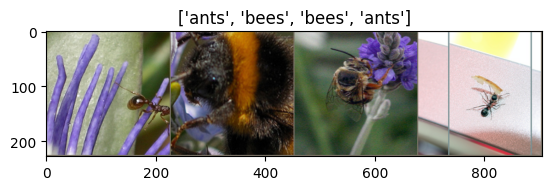

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 训练模型

我们来写一个训练模型的通用方法，会展示以下几点:

-  计划学习率
-  保存最好的模型

在下面，scheduler参数是一个从``torch.optim.lr_scheduler``来的学习率计划对象


In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### 可视化模型预测

用来展示数张图片预测的通用方法：

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning这个ConvNet

读取一个预训练模型，并且重置最后的全连接层。

In [7]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# 在这里把全连接层的输出改为2，即两个类别，可以用它来解决一个二分类问题
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### 训练和评估

在CPU上需要训练15-25分钟。在GPU上1分钟就够了。


In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7509 Acc: 0.5943
val Loss: 0.1716 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.5718 Acc: 0.7377
val Loss: 0.2042 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.4588 Acc: 0.8115
val Loss: 0.2505 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.3662 Acc: 0.8402
val Loss: 0.2162 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4613 Acc: 0.8156
val Loss: 0.2920 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.5304 Acc: 0.7910
val Loss: 0.3500 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.6557 Acc: 0.7336
val Loss: 0.5963 Acc: 0.8039

Epoch 7/24
----------
train Loss: 0.4240 Acc: 0.8361
val Loss: 0.2635 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.3473 Acc: 0.8607
val Loss: 0.3329 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3186 Acc: 0.8648
val Loss: 0.2177 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.2293 Acc: 0.8893
val Loss: 0.2075 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.2393 Acc: 0.8893
val Loss: 0.2052 Acc: 0.9346

Ep

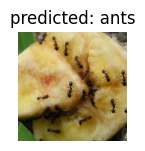

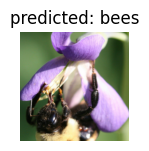

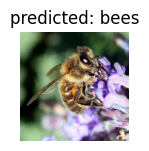

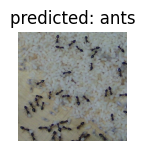

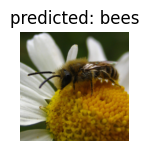

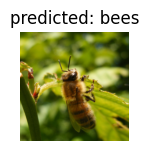

In [9]:
visualize_model(model_ft)

## 将ConvNet作为固定特征提取器

在这里，我们需要冻结除了最后一层以外的所有网络。我们需要将`requires_grad = False`设置为冻结参数，这样在`backward()`中就不会计算梯度。

您可以在[此处](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)阅读更多相关信息。


In [10]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### 训练和评估

在 CPU 上，与之前的情况相比，这将需要大约一半的时间。这是符合预期的，因为大部分网络不需要计算梯度。
然而，前向计算是需要的。


In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6482 Acc: 0.6311
val Loss: 0.2876 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.3802 Acc: 0.8238
val Loss: 0.6849 Acc: 0.7255

Epoch 2/24
----------
train Loss: 0.5620 Acc: 0.7418
val Loss: 0.1871 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4773 Acc: 0.7910
val Loss: 0.3637 Acc: 0.8497

Epoch 4/24
----------
train Loss: 0.5353 Acc: 0.7787
val Loss: 0.3371 Acc: 0.8693

Epoch 5/24
----------
train Loss: 0.5582 Acc: 0.7623
val Loss: 0.1564 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3403 Acc: 0.8689
val Loss: 0.1954 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.4353 Acc: 0.8197
val Loss: 0.1847 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3442 Acc: 0.8566
val Loss: 0.1891 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.4035 Acc: 0.8238
val Loss: 0.1964 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3597 Acc: 0.8648
val Loss: 0.1882 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3927 Acc: 0.8238
val Loss: 0.1683 Acc: 0.9542

Ep

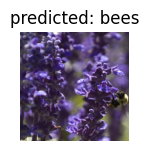

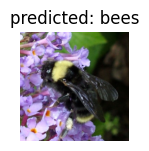

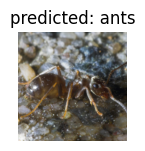

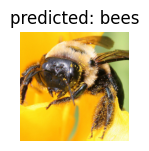

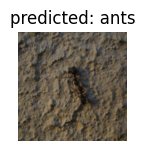

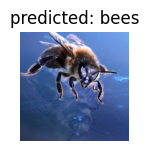

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## 在自定义图像上进行推理

使用训练好的模型，在自定义的图像上进行推理和可视化。


In [13]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])
        
        model.train(mode=was_training)

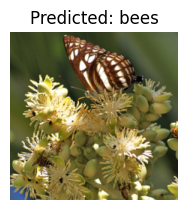

In [14]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

## Further Learning

If you would like to learn more about the applications of transfer learning,
checkout our [Quantized Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).



